# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Ames Housing dataset.

## Objectives

You will be able to:
- Implement interaction terms in Python using the `sklearn` and `statsmodels` packages 
- Interpret interaction variables in the context of a real-world problem 

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below: 

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [2]:
regression = LinearRegression()

Create a baseline model which includes all the variables we selected from the Ames housing data set to predict the house prices. Then use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [3]:
ames = pd.read_csv('ames.csv')

continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

data_cont = ames[continuous]

data_cat = pd.get_dummies(ames[categoricals], prefix = categoricals)

data = pd.concat([data_cont, data_cat], axis=1)
y = data['SalePrice']
X = data.drop('SalePrice', axis=1)

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

0.7773817128043183

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 3 interactions which have the biggest effect on our $R^2$, so print out the top 3 combinations.

You will create a `for` loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

Since there are so many different neighbourhoods we will exclude

In [4]:
from itertools import combinations

In [5]:
combs = combinations(X.columns, 2)

interactions = []
X_interact = X.copy()
for i, (a, b) in enumerate(combs):
    X_interact['interaction'] = X_interact[a] * X_interact[b]
    r2 = np.mean(cross_val_score(regression, X_interact, y, scoring='r2', cv=crossvalidation))
    if r2 > baseline:
        interactions.append((a, b, r2))
sort_inter = sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3]
print(sort_inter)


[('LotArea', 'Neighborhood_Edwards', 0.8093332224094569), ('GrLivArea', 'Neighborhood_Edwards', 0.8077114235220195), ('1stFlrSF', 'Neighborhood_Edwards', 0.8033414554230716)]


It looks like the top interactions involve the Neighborhood_Edwards feature so lets add the interaction between LotArea and Edwards to our model.

We can interpret this feature as the relationship between LotArea and SalePrice when the house is in Edwards or not.

## Visualize the Interaction

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against `SalePrice`. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

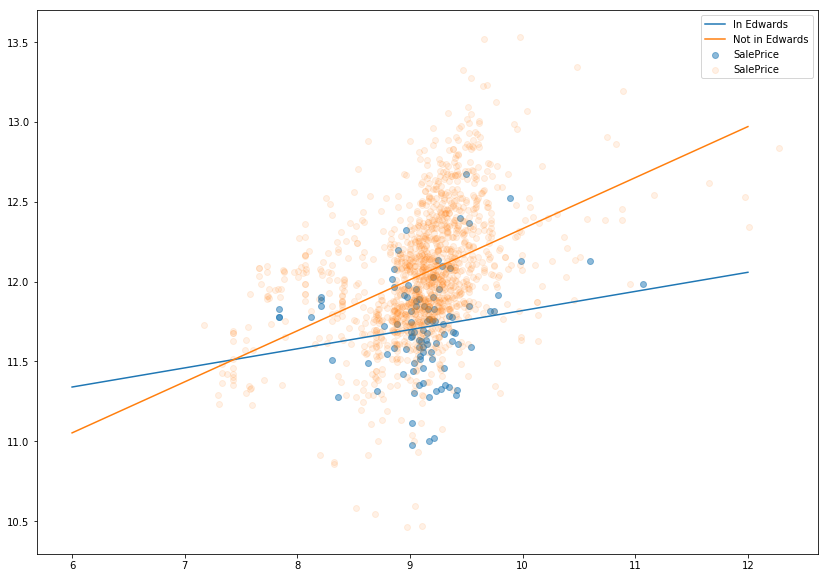

In [6]:
edwards = data.loc[data['Neighborhood_Edwards'] == 1]
not_edwards = data.loc[data['Neighborhood_Edwards'] == 0]
x = np.linspace(6, 12)

reg_1 = regression
reg_1.fit(np.log(edwards[['LotArea']]), np.log(edwards[['SalePrice']]))
preds_1 = reg_1.predict(x.reshape(-1, 1))

reg_2 = regression
reg_2.fit(np.log(not_edwards[['LotArea']]), np.log(not_edwards[['SalePrice']]))
preds_2 = reg_2.predict(x.reshape(-1,1))

# Visualization code here
fig, ax = plt.subplots(figsize=(14,10))

ax.scatter(np.log(edwards[['LotArea']]), np.log(edwards['SalePrice']), alpha=.5)
ax.plot(x, preds_1, label="In Edwards")

ax.scatter(np.log(not_edwards[['LotArea']]), np.log(not_edwards['SalePrice']), alpha=.1)
ax.plot(x, preds_2, label='Not in Edwards')

ax.legend()

## Build a final model with interactions

Use 10-fold cross-validation to build a model using the above interaction. 

In [7]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
new_X = X.copy()
new_X['LA*NE']=new_X['LotArea'] * new_X['Neighborhood_Edwards']

model = np.mean(cross_val_score(regression, new_X, y, scoring='r2', cv=crossvalidation))
model

0.8093332224094569

Our $R^2$ has increased considerably! Let's have a look in `statsmodels` to see if this interactions are significant.

In [8]:
import statsmodels.api as sm
new_X = sm.add_constant(new_X)
model_2 = sm.OLS(y, new_X)
results = model_2.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     148.6
Date:                Mon, 20 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:52:40   Log-Likelihood:                -17229.
No. Observations:                1460   AIC:                         3.456e+04
Df Residuals:                    1411   BIC:                         3.482e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.082e+04   4252.352      4.896      0.000    1.25e+04    2.92e+04
LotArea                  0.6108      0.103      5.916      0.000       0.408       0.813
1stFlrSF                35.0664      3.288     10.664      0.000      28.616      41.517
GrLivArea               58.1426      2.405     24.171      0.000      53.424      62.861
BldgType_1Fam         2.602e+04   2638.692      9.861      0.000    2.08e+04    3.12e+04
BldgType_2fmCon       9217.1096   5696.381      1.618      0.106   -1957.176    2.04e+04
BldgType_Duplex      -6841.6893   4591.768     -1.490      0.136   -1.58e+04    2165.737
BldgType_Twnhs       -1.026e+04   5569.935     -1.842      0.066   -2.12e+04     668.832
BldgType_TwnhsE       2679.5402   3722.000      0.720      0.472   -4621.708    9980.788
KitchenQual_Ex        5.641e+04   3780.490     14.921      0.000     4.9e+04    6.38e+04
KitchenQual_Fa       -2.433e+04   4554.502     -5.342      0.000   -3.33e+04   -1.54e+04
KitchenQual_Gd        2308.8324   2294.526      1.006      0.314   -2192.217    6809.881
KitchenQual_TA       -1.357e+04   2152.934     -6.302      0.000   -1.78e+04   -9345.160
SaleType_COD         -1.794e+04   6477.445     -2.769      0.006   -3.06e+04   -5228.796
SaleType_CWD          3318.0182   1.54e+04      0.216      0.829   -2.69e+04    3.35e+04
SaleType_Con          4.498e+04   2.17e+04      2.075      0.038    2451.689    8.75e+04
SaleType_ConLD       -1510.0213   1.11e+04     -0.136      0.892   -2.33e+04    2.02e+04
SaleType_ConLI        -889.2966   1.39e+04     -0.064      0.949   -2.82e+04    2.64e+04
SaleType_ConLw       -7014.0283   1.39e+04     -0.503      0.615   -3.44e+04    2.03e+04
SaleType_New          1.434e+04   5483.489      2.614      0.009    3579.608    2.51e+04
SaleType_Oth         -9223.3553   1.76e+04     -0.525      0.600   -4.37e+04    2.52e+04
SaleType_WD          -5248.4845   4613.283     -1.138      0.255   -1.43e+04    3801.147
MSZoning_C (all)     -1.969e+04   1.05e+04     -1.875      0.061   -4.03e+04     912.451
MSZoning_FV            1.83e+04   7715.456      2.371      0.018    3161.253    3.34e+04
MSZoning_RH          -1635.0973   7891.083     -0.207      0.836   -1.71e+04    1.38e+04
MSZoning_RL           9561.0427   3920.921      2.438      0.015    1869.582    1.73e+04
MSZoning_RM           1.428e+04   4419.309      3.232      0.001    5615.470     2.3e+04
Street_Grvl           1.203e+04   8875.663      1.356      0.175   -5377.530    2.94e+04
Street_Pave           8785.4294   6111.477      1.438      0.151   -3203.130    2.08e+04
Neighborhood_Blmngtn   1.02e+04   8807.813      1.158      0.247   -7077.770    2.75e+04
Neighborhood_Blueste  1.821e+04   2.29e+04      0.794      0.427   -2.68e+04    6.32e+04
Neighborhood_BrDale  -1003.6293   9697.145     -0.103    

What is your conclusion here?

The interaction between the 'Neighborhood_Edwards' and 'LotArea' categories is sigificant with a p value <.05.  The interaction also increased our R-squared, making our model a better fit as well.

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions can have a strong impact on linear regression models, and they should always be considered when you are constructing your models.